<a href="https://colab.research.google.com/github/Mustafa017/feedback_analysis/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


In [2]:
!pip install -qq transformers

     |████████████████████████████████| 3.4 MB 4.6 MB/s 
     |████████████████████████████████| 895 kB 60.9 MB/s 
     |████████████████████████████████| 596 kB 57.2 MB/s 
     |████████████████████████████████| 3.3 MB 48.5 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.15.0



In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 50.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 112MB/s]


In [5]:
!ls -a 

.  ..  apps.csv  .config  reviews.csv  sample_data


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer
import torch

In [8]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [9]:
print(df.shape, '\n')
df.info()

(15746, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


The Score and Review text have no missing values. That is great

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


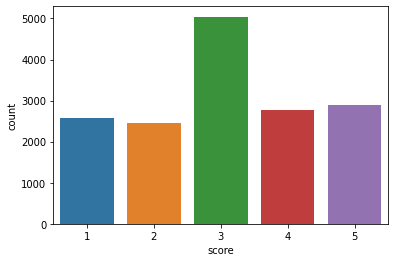

In [11]:
sns.countplot(df.score)

Most of the reviews have a score of 3 which indicates neutral comments. This is an imbalanced dataset. So we will create three sentiments positive, neutral, and negative. Then try and balance the scores among these three sentiments. Training the model on more of one data type will create a bias, which is what we are trying to avoid.

In [14]:
def score_to_sentiment(rating):
  """
  convert score to a sentiment
  negative = 0
  neutral = 1
  positive = 2

  Parameters
  ----------
  rating str

  return
  ------
  sentiment int 
  """
  rating = int(rating)
  if rating < 3:
    return 0
  elif rating > 3:
    return 2
  else:
    return 1

In [16]:
df['sentiment'] = df.score.apply(score_to_sentiment)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [18]:
sentiment_classes = ["negative", "neutral", "positive"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

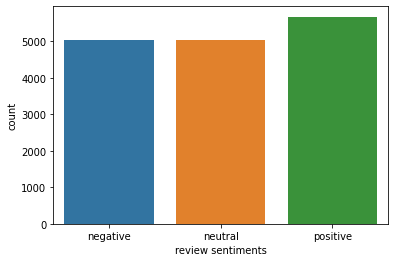

In [22]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiments')
ax.set_xticklabels(sentiment_classes)

The reviews are alomst equal and this solution provides a balanced dataset.

# Data Preprocessing
Machine learning models work with numbers only. So we need to convert the text to numbers. To achieve we need to use a tokenizer.

The Transformers library provides a variety of models e.g. BERT which includes prebuild tokenizers that help us with the conversions.

## Tokenizing (splitting strings in sub-word token strings)
A tokenizer is in charge of preparing the inputs for a model.
* Tokenizing (splitting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
* Adding new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
* Managing special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

In [26]:
#The cased version works better.
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [27]:
#load a pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's test how a tokenizer works. We can


*   convert text to tokens
*   convert tokens to token_ids



In [29]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original Sentence: {sample_text}')
print(f'Generated Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Original Sentence: When was I last outside? I am stuck at home for 2 weeks.
Generated Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


## Add Special tokens

BERT uses special tokens [CLS], [SEP], and [PAD] to understand input properly.

*   [SEP] A special token separating two different sentences in the same input.
*   [CLS] A special token representing the class of the input.
*   [PAD] A special token used to make arrays of tokens the same size for batching purpose. **Will then be ignored by attention mechanisms or loss computation.**
*   [UNK] A special token representing an out-of-vocabulary token.
*   [MASK] A special token representing a masked token.

In [31]:
print(f'{tokenizer.sep_token}, {tokenizer.sep_token_id}')
print(f'{tokenizer.cls_token}, {tokenizer.cls_token_id}')
print(f'{tokenizer.pad_token}, {tokenizer.pad_token_id}')
print(f'{tokenizer.unk_token}, {tokenizer.unk_token_id}')

[SEP], 102
[CLS], 101
[PAD], 0
[UNK], 100


* Special tokens are carefully handled by the tokenizer (they are never split).

* You can easily refer to special tokens using tokenizer class attributes like tokenizer.cls_token. This makes it easy to develop model-agnostic training and fine-tuning scripts.

All of that work (adding special tokens to the dataframe) can be done using the **encode_plus()** method:

In [52]:
encoding = tokenizer.encode_plus(sample_text, add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', 
                                 return_attention_mask=True, max_length=32, padding='max_length')
encoding

{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [53]:
print(encoding.keys(), '\n')

print(f"input_ids size: {len(encoding['input_ids'][0])}")
print(encoding['input_ids'][0], '\n')

print(f"attention mask size: {len(encoding['attention_mask'][0])}")
print(encoding['attention_mask'][0], '\n')

dict_keys(['input_ids', 'attention_mask']) 

input_ids size: 32
tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]) 

attention mask size: 32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) 



We can inverse the tokenization to have a look at the special tokens:


In [54]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choose Suitable Padding Length
BERT works with fixed-length sequences. 